In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
sns.set()

data = pd.read_excel('mean_salary.xlsx')
data.head()

,year,january,february,march,april,may,june,july,august,september,october,november,december
0,2013,26840,26620,28693,30026,29723,30986,30229,29226,29346,30069,30290,39648
1,2014,29535,29255,31486,32947,32272,33726,32515,30763,31929,32439,32546,42136
2,2015,30929,31325,32642,34377,34380,35395,33901,32176,32911,33357,33347,43408
3,2016,32660,33873,35501,36497,37270,38447,35888,35405,35843,35749,36195,47554
4,2017,34422,35497,37899,39225,39679,41454,38073,37099,38047,38333,38848,51197


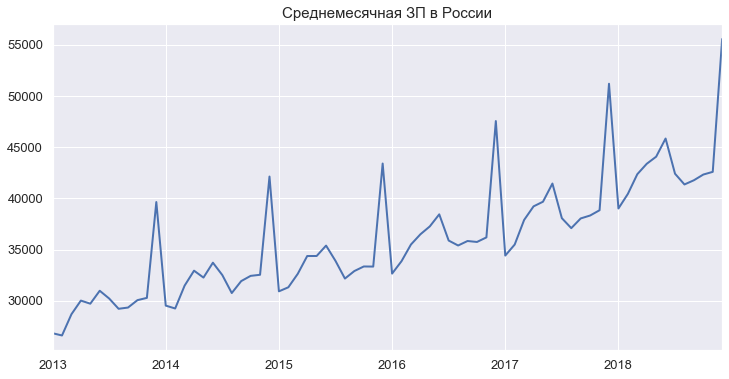

In [5]:
#сюда положим ряд, составленный из средних зп
salary_series = pd.Series()

for _, row in data.drop('year', axis=1).iterrows():
    salary_series = salary_series.append(pd.Series(row.values))

#используем даты в качестве индексов
salary_series.index = pd.date_range('2013-01-01', freq='M', periods=6*12)

#построим график
salary_series.plot(figsize=(12, 6), linewidth=2, fontsize=13)
plt.title('Среднемесячная ЗП в России', fontsize=15)
plt.show()

In [6]:
train_series = salary_series[salary_series.index.year<2018]
test_series = salary_series[salary_series.index.year==2018]

In [7]:
def cos(k, t, l):
    
    """
    Вспомогательная функция косинуса
    """
    return math.cos(math.pi*k*t/l)


def get_matrix_and_vector(period_i: np.ndarray) -> (np.ndarray, np.ndarray):
    
    """
    Возвращает матрицу и вектор свободных членов для нахождения коэффициентов Фурье для i-го периода.
    
    period_i - наблюдения i-го периода
    """
    
    l = len(period_i) - 1
    N = l
        
    y = np.empty((0,))
    matrix = np.empty((0, N+1))
    
    for t in range(0, l+1):
        #первое значение в каждой строке 1/2 -- множитель перед коэффициентом a_0
        row = np.array([.5])
        
        for k in range(1, N+1):
            row = np.append(row, cos(k, t, l))

        row = np.reshape(row, (1, N+1))
        matrix = np.append(matrix, row, axis=0)
        y = np.append(y, period_i[t])
 
    return matrix, y


def solve_system(M: np.ndarray, 
                 b: np.ndarray) -> np.ndarray:
    
    """
    Решает систему линейный уравнений
    M - основная матрица системы
    b - столбец свободных членов
    """
    
    assert np.linalg.det(M) != 0
    return np.linalg.solve(M, b)

In [8]:
def get_matrix_from_series(input_series: pd.Series, 
                           m: int, 
                           l: int):
    """
    Преобразует входной ряд в матрицу, 
    где каждая i-я строка -- наблюдения для i-го периода
    
    input_series -- входной ряд
    m -- количество периодов
    l - длина периода
    """
    
    return input_series.values.reshape(m, l)


def get_delay_matrix(input_vector: np.ndarray, 
                     p: int = 1) -> np.ndarray:
    """
    Строит матрицу задержек по входному вектору и величине задержек
    input_vector - входной вектор
    p - величина задержек
    """
    
    input_vector_copy = np.copy(input_vector)
    
    m = input_vector_copy.shape[0] % p
    
    #если длина ряда не кратна p, то удаляем несколько первых значений ряда
    if m != 0:
        input_vector_copy = np.delete(input_vector_copy, range(m))
    
    #определяем размерность матрицы зарежек
    row_dim = input_vector_copy.shape[0] // p
    col_dim = p
    
    #строим матрицу
    delay_matrix = np.resize(input_vector_copy, 
                             new_shape=(row_dim, col_dim)).T    
    
    return delay_matrix


def find_nearest(row: np.ndarray, 
                 p: int) -> set:
    """
    Возвращает индексы ближайших соседей для последнего элемента строки
    row - входная строка
    p - величина задержек
    """
    
    #количество соседей
    neighbors_cnt = 2 * p + 1
    
    last_element = row[-1]
    all_neighbors = row[:-1]

    #находим индексы ближайших соседей
    idx = set(np.argsort(np.abs(all_neighbors-last_element))[:neighbors_cnt])
        
    return idx


def predict_by_one_step(input_vector: np.ndarray, 
                        p: int = 1) -> float :
    """
    Прогнозирование на один шаг с помощью аналитического решения
    input_vector - входной вектор
    p - величина задержек
    """
    
    delay_matrix = get_delay_matrix(input_vector, p)
    last_row = delay_matrix[-1,:]
    nearest_neighbors_indexes = find_nearest(last_row, p)
    
    y = np.empty((0,))
    X = np.empty((0, p+1))
    for index in nearest_neighbors_indexes:
        y = np.append(y, delay_matrix[0, index+1])
        row = np.append(np.array([1]), delay_matrix[:, index])
        row = np.reshape(row, (1, p+1))
        X = np.append(X, row, axis=0)
    
    coef = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    prediction = sum(np.append(np.array([1]), delay_matrix[:, -1]) * coef)
    
    return prediction

In [9]:
def get_new_fourier_coefs(periods: np.ndarray, 
                          p: int = 1) -> list:
    
    """
    Возвращает коэффициенты Фурье для неизвестного периода
    periods - матрица наблюдений для известных периодов, где i-я строчка -- наблюдения i-го периода
    p - величина задержек
    
    """
    
    #список с предсказанными на след. период коэффициентами
    new_coefs = []
    
    #матрица с коэффициентами Фурье за все периоды. Строки -- коэфициенты за период
    coefs_for_all_periods = []
    
    for period in periods:
        
        X, y = get_matrix_and_vector(period)
        
        #находим коэффициенты Фурье, как решение системы линейных уравнений
        fourier_coef_for_period = solve_system(X, y)
        
        coefs_for_all_periods.append(fourier_coef_for_period)
    
    coefs_for_all_periods = np.array(coefs_for_all_periods)
    
    #Прогноз каждого коэффициента Фурье a_k для неизвестного периода
    #Каждый коэф. Фурье рассматривается как временной ряд, который прогнозируется на один шаг
    for i in range(coefs_for_all_periods.shape[1]):
        coef_for_next_period = predict_by_one_step(coefs_for_all_periods[:, i], p=p)
        new_coefs.append(coef_for_next_period)

    return new_coefs


def predict_next_period(new_coefs: list, 
                        l: int):
    """
    Прогнозирует временной ряд на неизвестный период
    
    new_coefs - коэффициенты Фурье для следующего периода
    l - длина периода
    """
    
    new_period = []
    for t in range(0, l):
        s = new_coefs[0] / 2
        for k in range(1, len(new_coefs)):
            s += new_coefs[k]*cos(k, t, l=l-1)

        new_period.append(s)
    
    return new_period

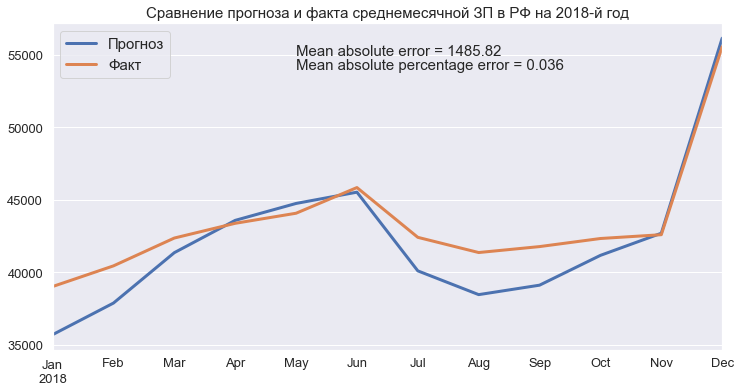

In [22]:
m = 5 #количество периодов в train выборке
l = 12 #длина периода
p = 1 #величина задержек

matrix = get_matrix_from_series(train_series, m, l)
new_coefs = get_new_fourier_coefs(matrix, p)
test_pred = predict_next_period(new_coefs, l)
test_pred = pd.Series(test_pred, index=test_series.index)

#ошибка прогноза
mae = round(mean_absolute_error(test_pred, test_series), 2)
mape = round(mean_absolute_percentage_error(test_series, test_pred), 3)


#построим график
test_pred.plot(figsize=(12, 6), linewidth=3, 
               fontsize=13, label='Прогноз')

test_series.plot(figsize=(12, 6), linewidth=3, 
                 fontsize=13, label='Факт')

plt.legend(fontsize=15)
plt.text(test_series.index[4], 55000, f'Mean absolute error = {mae}', fontsize=15)
plt.text(test_series.index[4], 54000, f'Mean absolute percentage error = {mape}', fontsize=15)
plt.title('Сравнение прогноза и факта среднемесячной ЗП в РФ на 2018-й год', fontsize=15)
plt.show()